# Load and Inspect Data

In [1]:
import pandas as pd

# Load the dataset from GitHub
csv_url = "https://raw.githubusercontent.com/xyzesther/decoding_digital_personas/main/data/mbti_1.csv"
df = pd.read_csv(csv_url)

print(f"Dataset shape: {df.shape}\n")

df.head()

# Remove missing values and reset index
df = df.dropna().reset_index(drop=True)

# Display unique MBTI types
print("Unique MBTI Types:\n", df['type'].unique())

Dataset shape: (8675, 2)

Unique MBTI Types:
 ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


### Distribution of the data

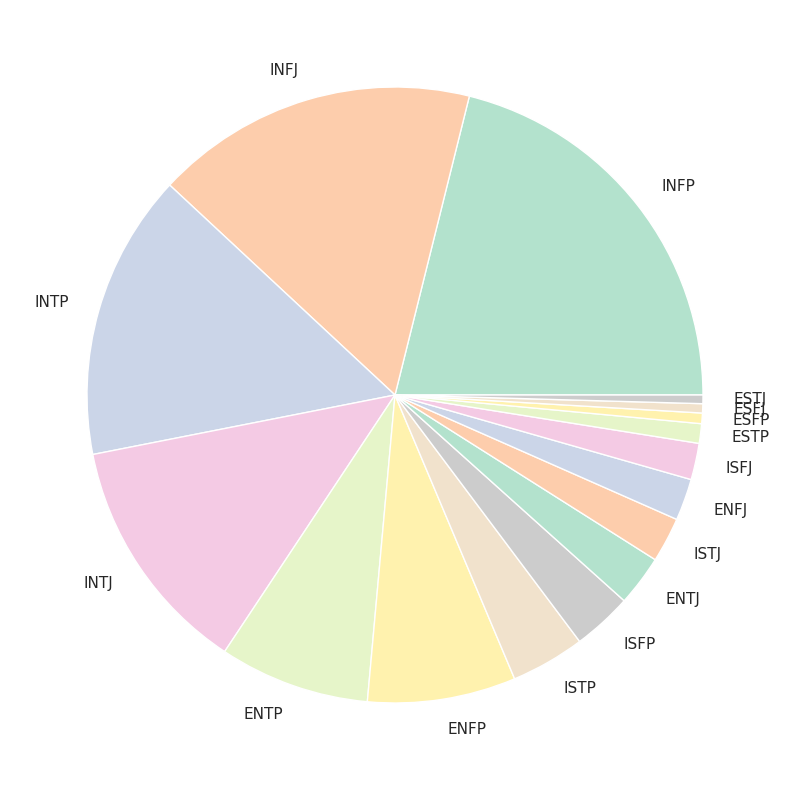

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of MBTI types
mbti_dict = df['type'].value_counts().to_dict()
mbti = list(mbti_dict.keys())
vals = list(mbti_dict.values())

sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (10,10))
plt.pie(vals, labels = mbti, colors = plt.cm.Pastel2.colors)
plt.show()

#### Distribution By MBTI Traits

In [3]:
# Convert MBTI labels into four binary features (E/I, S/N, T/F, J/P)
def mbti_to_binary(mbti_type):
    return [
        1 if mbti_type[0] == 'E' else 0,
        1 if mbti_type[1] == 'S' else 0,
        1 if mbti_type[2] == 'T' else 0,
        1 if mbti_type[3] == 'J' else 0
    ]

df[['E/I', 'S/N', 'T/F', 'J/P']] = df['type'].apply(lambda x: pd.Series(mbti_to_binary(x)))

df.head()


,type,posts,E/I,S/N,T/F,J/P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,1


In [4]:
print(df["E/I"].value_counts())
print(df["S/N"].value_counts())
print(df["T/F"].value_counts())
print(df["J/P"].value_counts())

E/I
0    6676
1    1999
Name: count, dtype: int64
S/N
0    7478
1    1197
Name: count, dtype: int64
T/F
0    4694
1    3981
Name: count, dtype: int64
J/P
0    5241
1    3434
Name: count, dtype: int64


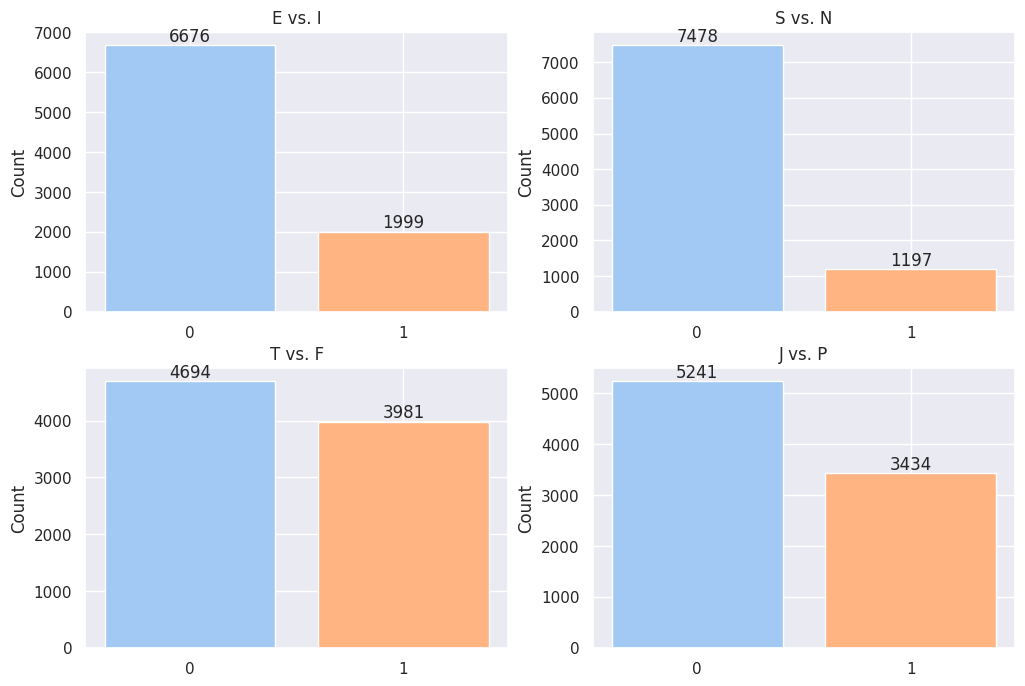

In [5]:
# Show the trait distribution in histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
colors = sns.color_palette("pastel")

def bar_plot(colors, ax, title, col):
    bars = ax.bar(x = df[col].value_counts().index,
           height=df[col].value_counts().values,
           color=colors,
           tick_label = df[col].value_counts().index)
    ax.set_title(title)
    ax.set_ylabel("Count")

    for bar in bars:
      height = bar.get_height()
      ax.text(bar.get_x() + bar.get_width() / 2, height,
              int(height),
              ha="center", va="bottom")

bar_plot(colors, axs[0][0], "E vs. I", "E/I" )
bar_plot(colors, axs[0][1], "S vs. N", "S/N" )
bar_plot(colors, axs[1][0], "T vs. F", "T/F")
bar_plot(colors, axs[1][1], "J vs. P", "J/P")

# Use BERT + MLP model

In [6]:
# Join the 50 posts into one text string and remove URLs
import re

def clean_and_join(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    return " ".join(text.split("|||"))

def mbti_to_binary(mbti_type):
    return [
        1 if mbti_type[0] == 'E' else 0,
        1 if mbti_type[1] == 'S' else 0,
        1 if mbti_type[2] == 'T' else 0,
        1 if mbti_type[3] == 'J' else 0
    ]

df["clean_text_bert"] = df["posts"].apply(clean_and_join)
df["labels"] = df["type"].apply(mbti_to_binary)

In [7]:
from sklearn.model_selection import train_test_split

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text_bert"].tolist(), df["labels"].tolist(), test_size=0.2, random_state=42
)

In [8]:
# Dataset class
from torch.utils.data import Dataset, DataLoader

class MBTIDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, return_tensors="pt", max_length=self.max_len,
                                padding="max_length", truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return inputs["input_ids"], inputs["attention_mask"], label

    def __len__(self):
        return len(self.texts)


In [9]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# BERT + MLP model
class BertMLPClassifier(nn.Module):
    def __init__(self, pretrained_model="bert-base-uncased"):
        super(BertMLPClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        self.classifier = nn.Sequential(
            nn.Linear(768, 50),
            nn.ReLU(),
            nn.Linear(50, 4)  # 4 MBTI binary traits
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.pooler_output
        return self.classifier(cls_output)

In [21]:
# Prepare data loaders and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_dataset = MBTIDataset(train_texts, train_labels, tokenizer)
val_dataset = MBTIDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
model = BertMLPClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Using cuda device


In [22]:
# Compute pos_weight to handle label imbalance
y_array = np.array(train_labels)
pos_weights = torch.tensor([(len(y_array) / y_array[:, i].sum()) for i in range(4)]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [23]:
# Learning rate scheduler with warmup + decay
from transformers import get_linear_schedule_with_warmup

epochs = 10
patience = 3  # for early stopping
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

In [24]:
from tqdm import tqdm

# Train the model
best_loss = float('inf')
patience_counter = 0
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, (input_ids, attention_mask, labels) in enumerate(tqdm(train_loader)):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if step % 50 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch+1}, Step {step}: Learning Rate = {current_lr:.8f}")

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Avg Loss: {avg_loss:.4f}")

    # early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 1, Step 0: Learning Rate = 0.00000005


 12%|█▏        | 50/434 [00:46<05:59,  1.07it/s]

Epoch 1, Step 50: Learning Rate = 0.00000235


 23%|██▎       | 100/434 [01:33<05:19,  1.05it/s]

Epoch 1, Step 100: Learning Rate = 0.00000465


 35%|███▍      | 150/434 [02:20<04:32,  1.04it/s]

Epoch 1, Step 150: Learning Rate = 0.00000696


 46%|████▌     | 200/434 [03:08<03:43,  1.05it/s]

Epoch 1, Step 200: Learning Rate = 0.00000926


 58%|█████▊    | 250/434 [03:56<02:55,  1.05it/s]

Epoch 1, Step 250: Learning Rate = 0.00001157


 69%|██████▉   | 300/434 [04:44<02:08,  1.04it/s]

Epoch 1, Step 300: Learning Rate = 0.00001387


 81%|████████  | 350/434 [05:32<01:20,  1.04it/s]

Epoch 1, Step 350: Learning Rate = 0.00001618


 92%|█████████▏| 400/434 [06:20<00:32,  1.04it/s]

Epoch 1, Step 400: Learning Rate = 0.00001848


100%|██████████| 434/434 [06:52<00:00,  1.05it/s]


Epoch 1 | Avg Loss: 1.1329


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 2, Step 0: Learning Rate = 0.00001999


 12%|█▏        | 50/434 [00:48<06:08,  1.04it/s]

Epoch 2, Step 50: Learning Rate = 0.00001974


 23%|██▎       | 100/434 [01:36<05:20,  1.04it/s]

Epoch 2, Step 100: Learning Rate = 0.00001948


 35%|███▍      | 150/434 [02:24<04:32,  1.04it/s]

Epoch 2, Step 150: Learning Rate = 0.00001923


 46%|████▌     | 200/434 [03:12<03:41,  1.06it/s]

Epoch 2, Step 200: Learning Rate = 0.00001897


 58%|█████▊    | 250/434 [04:00<02:55,  1.05it/s]

Epoch 2, Step 250: Learning Rate = 0.00001871


 69%|██████▉   | 300/434 [04:48<02:08,  1.04it/s]

Epoch 2, Step 300: Learning Rate = 0.00001846


 81%|████████  | 350/434 [05:36<01:20,  1.04it/s]

Epoch 2, Step 350: Learning Rate = 0.00001820


 92%|█████████▏| 400/434 [06:24<00:32,  1.03it/s]

Epoch 2, Step 400: Learning Rate = 0.00001795


100%|██████████| 434/434 [06:57<00:00,  1.04it/s]


Epoch 2 | Avg Loss: 1.0416


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 3, Step 0: Learning Rate = 0.00001777


 12%|█▏        | 50/434 [00:47<06:05,  1.05it/s]

Epoch 3, Step 50: Learning Rate = 0.00001752


 23%|██▎       | 100/434 [01:36<05:19,  1.05it/s]

Epoch 3, Step 100: Learning Rate = 0.00001726


 35%|███▍      | 150/434 [02:24<04:31,  1.05it/s]

Epoch 3, Step 150: Learning Rate = 0.00001700


 46%|████▌     | 200/434 [03:12<03:46,  1.03it/s]

Epoch 3, Step 200: Learning Rate = 0.00001675


 58%|█████▊    | 250/434 [04:00<02:56,  1.04it/s]

Epoch 3, Step 250: Learning Rate = 0.00001649


 69%|██████▉   | 300/434 [04:48<02:09,  1.04it/s]

Epoch 3, Step 300: Learning Rate = 0.00001624


 81%|████████  | 350/434 [05:36<01:21,  1.03it/s]

Epoch 3, Step 350: Learning Rate = 0.00001598


 92%|█████████▏| 400/434 [06:24<00:32,  1.04it/s]

Epoch 3, Step 400: Learning Rate = 0.00001572


100%|██████████| 434/434 [06:57<00:00,  1.04it/s]


Epoch 3 | Avg Loss: 0.9055


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 4, Step 0: Learning Rate = 0.00001555


 12%|█▏        | 50/434 [00:47<06:10,  1.04it/s]

Epoch 4, Step 50: Learning Rate = 0.00001529


 23%|██▎       | 100/434 [01:35<05:25,  1.03it/s]

Epoch 4, Step 100: Learning Rate = 0.00001504


 35%|███▍      | 150/434 [02:23<04:30,  1.05it/s]

Epoch 4, Step 150: Learning Rate = 0.00001478


 46%|████▌     | 200/434 [03:11<03:44,  1.04it/s]

Epoch 4, Step 200: Learning Rate = 0.00001453


 58%|█████▊    | 250/434 [04:00<03:00,  1.02it/s]

Epoch 4, Step 250: Learning Rate = 0.00001427


 69%|██████▉   | 300/434 [04:49<02:08,  1.04it/s]

Epoch 4, Step 300: Learning Rate = 0.00001401


 81%|████████  | 350/434 [05:37<01:22,  1.02it/s]

Epoch 4, Step 350: Learning Rate = 0.00001376


 92%|█████████▏| 400/434 [06:25<00:32,  1.04it/s]

Epoch 4, Step 400: Learning Rate = 0.00001350


100%|██████████| 434/434 [06:58<00:00,  1.04it/s]


Epoch 4 | Avg Loss: 0.7546


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 5, Step 0: Learning Rate = 0.00001333


 12%|█▏        | 50/434 [00:48<06:05,  1.05it/s]

Epoch 5, Step 50: Learning Rate = 0.00001307


 23%|██▎       | 100/434 [01:35<05:19,  1.04it/s]

Epoch 5, Step 100: Learning Rate = 0.00001282


 35%|███▍      | 150/434 [02:24<04:33,  1.04it/s]

Epoch 5, Step 150: Learning Rate = 0.00001256


 46%|████▌     | 200/434 [03:12<03:47,  1.03it/s]

Epoch 5, Step 200: Learning Rate = 0.00001230


 58%|█████▊    | 250/434 [04:00<02:56,  1.04it/s]

Epoch 5, Step 250: Learning Rate = 0.00001205


 69%|██████▉   | 300/434 [04:48<02:09,  1.03it/s]

Epoch 5, Step 300: Learning Rate = 0.00001179


 81%|████████  | 350/434 [05:36<01:21,  1.03it/s]

Epoch 5, Step 350: Learning Rate = 0.00001154


 92%|█████████▏| 400/434 [06:24<00:32,  1.05it/s]

Epoch 5, Step 400: Learning Rate = 0.00001128


100%|██████████| 434/434 [06:57<00:00,  1.04it/s]


Epoch 5 | Avg Loss: 0.5956


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 6, Step 0: Learning Rate = 0.00001111


 12%|█▏        | 50/434 [00:48<06:10,  1.04it/s]

Epoch 6, Step 50: Learning Rate = 0.00001085


 23%|██▎       | 100/434 [01:36<05:19,  1.05it/s]

Epoch 6, Step 100: Learning Rate = 0.00001059


 35%|███▍      | 150/434 [02:24<04:29,  1.05it/s]

Epoch 6, Step 150: Learning Rate = 0.00001034


 46%|████▌     | 200/434 [03:12<03:46,  1.03it/s]

Epoch 6, Step 200: Learning Rate = 0.00001008


 58%|█████▊    | 250/434 [04:00<02:57,  1.03it/s]

Epoch 6, Step 250: Learning Rate = 0.00000983


 69%|██████▉   | 300/434 [04:48<02:08,  1.05it/s]

Epoch 6, Step 300: Learning Rate = 0.00000957


 81%|████████  | 350/434 [05:36<01:21,  1.03it/s]

Epoch 6, Step 350: Learning Rate = 0.00000931


 92%|█████████▏| 400/434 [06:24<00:32,  1.04it/s]

Epoch 6, Step 400: Learning Rate = 0.00000906


100%|██████████| 434/434 [06:56<00:00,  1.04it/s]


Epoch 6 | Avg Loss: 0.4707


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 7, Step 0: Learning Rate = 0.00000888


 12%|█▏        | 50/434 [00:47<06:11,  1.03it/s]

Epoch 7, Step 50: Learning Rate = 0.00000863


 23%|██▎       | 100/434 [01:35<05:21,  1.04it/s]

Epoch 7, Step 100: Learning Rate = 0.00000837


 35%|███▍      | 150/434 [02:23<04:31,  1.05it/s]

Epoch 7, Step 150: Learning Rate = 0.00000812


 46%|████▌     | 200/434 [03:11<03:44,  1.04it/s]

Epoch 7, Step 200: Learning Rate = 0.00000786


 58%|█████▊    | 250/434 [03:59<02:57,  1.04it/s]

Epoch 7, Step 250: Learning Rate = 0.00000760


 69%|██████▉   | 300/434 [04:48<02:08,  1.05it/s]

Epoch 7, Step 300: Learning Rate = 0.00000735


 81%|████████  | 350/434 [05:36<01:22,  1.02it/s]

Epoch 7, Step 350: Learning Rate = 0.00000709


 92%|█████████▏| 400/434 [06:24<00:32,  1.04it/s]

Epoch 7, Step 400: Learning Rate = 0.00000684


100%|██████████| 434/434 [06:56<00:00,  1.04it/s]


Epoch 7 | Avg Loss: 0.3722


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 8, Step 0: Learning Rate = 0.00000666


 12%|█▏        | 50/434 [00:48<06:11,  1.03it/s]

Epoch 8, Step 50: Learning Rate = 0.00000641


 23%|██▎       | 100/434 [01:36<05:24,  1.03it/s]

Epoch 8, Step 100: Learning Rate = 0.00000615


 35%|███▍      | 150/434 [02:24<04:31,  1.05it/s]

Epoch 8, Step 150: Learning Rate = 0.00000589


 46%|████▌     | 200/434 [03:12<03:44,  1.04it/s]

Epoch 8, Step 200: Learning Rate = 0.00000564


 58%|█████▊    | 250/434 [04:00<02:57,  1.04it/s]

Epoch 8, Step 250: Learning Rate = 0.00000538


 69%|██████▉   | 300/434 [04:48<02:07,  1.05it/s]

Epoch 8, Step 300: Learning Rate = 0.00000513


 81%|████████  | 350/434 [05:36<01:20,  1.04it/s]

Epoch 8, Step 350: Learning Rate = 0.00000487


 92%|█████████▏| 400/434 [06:25<00:32,  1.03it/s]

Epoch 8, Step 400: Learning Rate = 0.00000461


100%|██████████| 434/434 [06:57<00:00,  1.04it/s]


Epoch 8 | Avg Loss: 0.3079


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 9, Step 0: Learning Rate = 0.00000444


 12%|█▏        | 50/434 [00:48<06:11,  1.03it/s]

Epoch 9, Step 50: Learning Rate = 0.00000418


 23%|██▎       | 100/434 [01:36<05:21,  1.04it/s]

Epoch 9, Step 100: Learning Rate = 0.00000393


 35%|███▍      | 150/434 [02:24<04:35,  1.03it/s]

Epoch 9, Step 150: Learning Rate = 0.00000367


 46%|████▌     | 200/434 [03:12<03:45,  1.04it/s]

Epoch 9, Step 200: Learning Rate = 0.00000342


 58%|█████▊    | 250/434 [04:00<02:55,  1.05it/s]

Epoch 9, Step 250: Learning Rate = 0.00000316


 69%|██████▉   | 300/434 [04:49<02:10,  1.02it/s]

Epoch 9, Step 300: Learning Rate = 0.00000290


 81%|████████  | 350/434 [05:37<01:20,  1.04it/s]

Epoch 9, Step 350: Learning Rate = 0.00000265


 92%|█████████▏| 400/434 [06:25<00:32,  1.04it/s]

Epoch 9, Step 400: Learning Rate = 0.00000239


100%|██████████| 434/434 [06:58<00:00,  1.04it/s]


Epoch 9 | Avg Loss: 0.2636


  0%|          | 0/434 [00:00<?, ?it/s]

Epoch 10, Step 0: Learning Rate = 0.00000222


 12%|█▏        | 50/434 [00:48<06:08,  1.04it/s]

Epoch 10, Step 50: Learning Rate = 0.00000196


 23%|██▎       | 100/434 [01:36<05:18,  1.05it/s]

Epoch 10, Step 100: Learning Rate = 0.00000171


 35%|███▍      | 150/434 [02:23<04:31,  1.05it/s]

Epoch 10, Step 150: Learning Rate = 0.00000145


 46%|████▌     | 200/434 [03:12<03:44,  1.04it/s]

Epoch 10, Step 200: Learning Rate = 0.00000119


 58%|█████▊    | 250/434 [04:00<02:58,  1.03it/s]

Epoch 10, Step 250: Learning Rate = 0.00000094


 69%|██████▉   | 300/434 [04:48<02:11,  1.02it/s]

Epoch 10, Step 300: Learning Rate = 0.00000068


 81%|████████  | 350/434 [05:37<01:22,  1.02it/s]

Epoch 10, Step 350: Learning Rate = 0.00000042


 92%|█████████▏| 400/434 [06:25<00:32,  1.04it/s]

Epoch 10, Step 400: Learning Rate = 0.00000017


100%|██████████| 434/434 [06:58<00:00,  1.04it/s]


Epoch 10 | Avg Loss: 0.2403


100%|██████████| 109/109 [00:54<00:00,  1.99it/s]



Classification Report (per MBTI dimension):

              precision    recall  f1-score   support

         E/I       0.57      0.59      0.58       382
         S/N       0.49      0.48      0.49       246
         T/F       0.73      0.76      0.74       798
         J/P       0.61      0.65      0.63       669

   micro avg       0.63      0.66      0.65      2095
   macro avg       0.60      0.62      0.61      2095
weighted avg       0.63      0.66      0.65      2095
 samples avg       0.51      0.52      0.49      2095



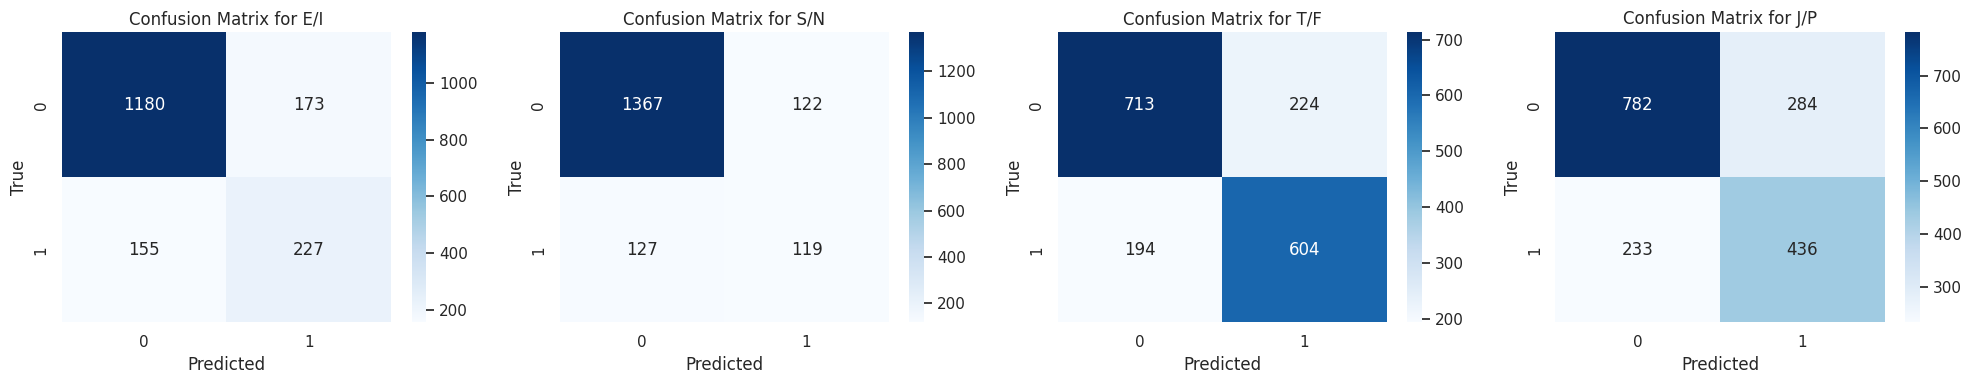

In [25]:
import numpy as np
from sklearn.metrics import classification_report, multilabel_confusion_matrix

# Evaluate the model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for input_ids, attention_mask, labels in tqdm(val_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("\nClassification Report (per MBTI dimension):\n")
print(classification_report(np.array(y_true), np.array(y_pred), target_names=["E/I", "S/N", "T/F", "J/P"], zero_division=0))

# Confusion Matrix
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)
labels = ["E/I", "S/N", "T/F", "J/P"]
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i in range(4):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for {labels[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
plt.tight_layout()
plt.show()

In [29]:
# Predict MBTI traits for a single input text
def predict_mbti(text):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        binary_output = [1 if p >= 0.5 else 0 for p in probs]
        mbti_traits = ["E" if binary_output[0] else "I",
                       "S" if binary_output[1] else "N",
                       "T" if binary_output[2] else "F",
                       "J" if binary_output[3] else "P"]
        return "".join(mbti_traits), probs

example_text = "I love exploring new places and meeting people. I tend to be logical and like to make decisions quickly."
pred_type, confidence = predict_mbti(example_text)
print(f"Predicted MBTI type: {pred_type}")
print(f"Trait confidences: {confidence}")


Predicted MBTI type: ISFP
Trait confidences: [0.40597346 0.9779463  0.21181937 0.33380845]
